# Bolidozor vs optical trajectories - correlation example

**Pred prvnim spustenim inicializujte funkce a importujte moduly, které jsou na konci tohoto notebooku

také musí být na počítači nainstalováni MLABvoClient '''sudo pip3 install MLABvo'''



## jak to celé má fungovat?
(současný stav)

 * Vybrat shodu, ručně určit přibližně dráhu (zatím přesně)
 * Získat jednu shodu
 * Určit časový offset u každé detekce + stanovit nejmenší a největší čas ze všech dat.
 * Nepřesně určit dopplera pro dráhu + najít 'nulu' pro každou detekci
 * dopplera pro dráhu zpřesnit na úroveň vzorku v rozmezí n s od extrémních časů minim nulových dopplerů (tzn. reálných headeach)
 * Z dopplera vygenerovat signál
 * 
 * 
 * ....

#
# Inicializace

K inicializaci před prvnim spustenim:

In [1]:
import MLABvo.Bolidozor
import MLABvo.BolidozorTools
import numpy as np
import scipy, scipy.constants
import scipy, scipy.signal
from Geocentric import Geocentric
import matplotlib.pyplot as plt
from astropy.io import fits
import datetime
from matplotlib import dates
import recviewer

def generate_path(start_point, stop_point, velocity, timesteps):
    points = np.empty([timesteps.size, 3])
    #start_lat, start_lon, start_alt = start
    #stop_lat, stop_lon, stop_alt = end
    #start_point = np.array(geoC.GeographicToGeocentric(start_lat, start_lon, start_alt))
    #stop_point = np.array(geoC.GeographicToGeocentric(stop_la, stop_lon, stop_alt))
    met_vect = stop_point - start_point
    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        points[i] =  start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * velocity))
    return(points)

# Events

jednotlivé události meteorů. Obsahují ID z bolidozoru a reálnou trajektorii...

In [2]:
if False:#2057410
    multibolid_id = 2057410
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([44980.37638663])

    met_stop_lat = np.array([48.340593635025])
    met_stop_lon = np.array([6.572188010297])

    met_start_lat = np.array([49.52717828089])
    met_start_lon = np.array([6.763558272451])
    
    met_velocity = [45500]
    model_offset = -8.25

In [3]:
if True:#2047621
    multibolid_id = 2047621
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([41896.884619396])

    met_start_lat = np.array([49.997439391249])
    met_start_lon = np.array([9.692504979925])

    met_stop_lat = np.array([50.035327181108])
    met_stop_lon = np.array([7.560013628387])

    met_velocity = [25000]
    model_offset = 1.440

In [4]:
if True: # 2017-12-12 20:3015
         # http://fireball.imo.net/members/imo_view/event/2017/5190
    multibolid_id = 2315086
    met_start_altitude = np.array([55000.0])
    met_stop_altitude = np.array([42000.7633450924])

    met_stop_lon = np.array([9.303839])
    met_stop_lat = np.array([51.844657845132])
    
    met_start_lon = np.array([9.303839])
    met_start_lat = np.array([52.512474019106])

    met_velocity = [30500]
    model_offset = 3

In [5]:
if True:#2017388
    multibolid_id = 2017388
    met_start_altitude = np.array([127870])
    met_stop_altitude = np.array([70000])

    met_stop_lon = np.array([6.512636353428])
    met_stop_lat = np.array([51.944553218498])
    
    met_start_lon = np.array([9.996094184309])
    met_start_lat = np.array([51.230870109095])

    met_velocity = [31000]
    model_offset = 7.94

In [3]:
if True:#2017-01-31
    multibolid_id = [34059317, 34059265, 34059249, 34059285, 34059251]
    met_start_altitude = np.array([55000.0])
    met_stop_altitude = np.array([8910.7633450924])

    met_stop_lon = np.array([9.654562])
    met_stop_lat = np.array([45.338965])
    
    met_start_lon = np.array([9.917798])
    met_start_lat = np.array([45.213897])

    met_velocity = [30500]
    model_offset = 7.94

In [4]:
geoC = Geocentric(6378137, 6356752.314)
stations = {}
stations['SVAKOV-R12']={'name': 'SVAKOV','latitude':49.2607,'longitude':14.6917,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['ZVPP-R6']={'name': 'ZVPP','latitude':48.9869,'longitude':14.4675,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['HFN-R1']={'name': 'JHRADEC','latitude':49.1314,'longitude': 14.9999,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['VALMEZ-R1']={'name': 'VALMEZ','latitude':49.463038,'longitude': 17.973544,'elevation':400, 'status': 'testing', 'type': 'receiver'}
stations['DDMTREBIC-R3']={'name': 'DDMTREBIC','latitude':49.2071,'longitude':15.8759,'elevation':480, 'status': 'operational', 'type': 'receiver'}
stations['OBSUPICE-R6']={'name': 'OBSUPICE','latitude':50.5067,'longitude':16.0115,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['NACHODSKO-R5']={'name': 'TREBIC','latitude':49.2071,'longitude':15.8759,'elevation':480, 'status': 'operational', 'type': 'receiver'}

c = scipy.constants.c
trans_station_point = np.array(geoC.GeographicToGeocentric(47.347993, 5.515079, 190))
t = 0.005
t = 1/96000
t = 1/96000*1000

timesteps = np.arange(-20,5,t)

In [8]:
# Slouzi pro vyber z DB shod

bz = MLABvo.Bolidozor.Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)

{'api_url': 'http://api.vo.astro.cz/bolidozor/', 'datetime_start': '2018-02-16 02:04:08.350942', 'api_version': '0.0.2', 'job_id': '656e185a-ac68-40d7-b3b5-fea3fc28a1bf', 'job_result_url': 'http://api.vo.astro.cz/bolidozor/job/656e185a-ac68-40d7-b3b5-fea3fc28a1bf', 'job_state': 'PENDING'}


In [5]:
# Slouzi pro vyber z jednotlivych eventu

bz = MLABvo.Bolidozor.Bolidozor()
bolids = bz.getMeteor(id = multibolid_id)

{'job_result_url': 'http://api.vo.astro.cz/bolidozor/job/e1e55290-5050-43a3-b480-2dfa6dd97d43', 'datetime_start': '2018-02-16 02:04:25.690389', 'job_state': 'PENDING', 'job_id': 'e1e55290-5050-43a3-b480-2dfa6dd97d43', 'api_version': '0.0.2', 'api_url': 'http://api.vo.astro.cz/bolidozor/'}


# Časové zarovnání

Následující blok najde GPS značky v RAW souborech a k navrácené hodnotě z bolidozoru přidá informace o offsetu a zkalibrovaný čas. Tato data je pak možné dále používat. Na konci to vykreslí zarovnaný průběh signálu v čase.

Help on function timeCalibration in module MLABvo.Bolidozor:

timeCalibration(raw_file, station=None, sigma=15, debug=True, browse_around=True, sigma_around=None, time_around=36000, smooth_distance=15, low_cut=10, high_cut=500.0, filter_order=3)


 0 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2018/01/31/03/20180131030544222_OBSUPICE-R6_met.fits
OBSUPICE-R6
hledam alternativni zdroj presneho casu
OBSUPICE-R6 True
Okolnich souboru: 19
+----++-+-+-++++--+

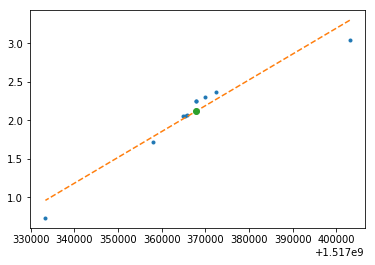

popis krivky m, b: 3.35031306448e-05 -50834.4547532
Neznama SAMPCORRECTION proto pouzivam z vypoctu 2.12161710821
Zpracovavam soubor: http://space.astro.cz/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2018/01/31/03/20180131030544222_OBSUPICE-R6_raws.fits
delka zaznamu          : 6.8 s
cas prvni. vzorku s GPS: 0 s
cas 1. GPS a konec     : 6.8 s
SysCas ukladani souboru: 2018-01-31 03:05:48 s
SysCas zacatku souboru : 2018-01-31 03:05:41.200000
SysCas 1. GPS znacky   : 2018-01-31 03:05:41.200000
Korekce systemoveho cas: 0:00:00
Korekce casu zvukovky  : 2.12161710821 s
CorCas ukladani souboru: 2018-01-31 03:05:48.900383 s
CorCas zacatku souboru : 2018-01-31 03:05:42.100383
CorCas 1. GPS znacky   : 2018-01-31 03:05:42.100383
Kvalita souboru        : 50
Pocet vzorku s gps znac: 0


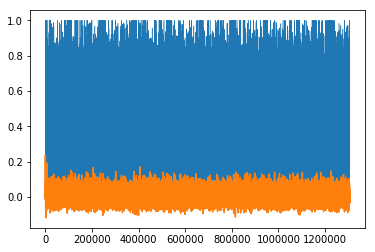


 1 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2018/01/31/03/20180131030539443_OBSUPICE-R6_met.fits
OBSUPICE-R6
Zpracovavam soubor: http://space.astro.cz/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2018/01/31/03/20180131030539443_OBSUPICE-R6_raws.fits
delka zaznamu          : 7.4 s
cas prvni. vzorku s GPS: 2.8080989583333333 s
cas 1. GPS a konec     : 4.591901041666667 s
SysCas ukladani souboru: 2018-01-31 03:05:44 s
SysCas zacatku souboru : 2018-01-31 03:05:36.600000
SysCas 1. GPS znacky   : 2018-01-31 03:05:39.408099
Korekce systemoveho cas: 0:00:00.591901
Korekce casu zvukovky  : 2.251099109649658 s
CorCas ukladani souboru: 2018-01-31 03:05:44.591901 s
CorCas zacatku souboru : 2018-01-31 03:05:37.191901
CorCas 1. GPS znacky   : 2018-01-31 03:05:40
Kvalita souboru        : 100
Pocet vzorku s gps znac: 81


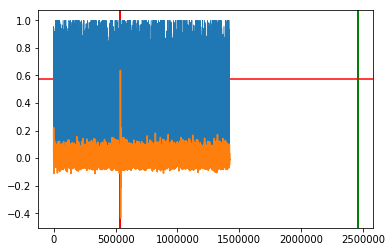


 2 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/nachodsko/NACHODSKO-R5/meteors/2018/01/31/03/20180131030618894_NACHODSKO-R5_met.fits
NACHODSKO-R5
hledam alternativni zdroj presneho casu
NACHODSKO-R5 True
Okolnich souboru: 13
-------------ERROR, bolids.result: too many indices for array

 3 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2018/01/31/03/20180131030546295_DDMTREBIC-R3_met.fits
DDMTREBIC-R3
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2018/01/31/03/20180131030546295_DDMTREBIC-R3_raws.fits
delka zaznamu          : 30.4 s
cas prvni. vzorku s GPS: 5.050463541666667 s
cas 1. GPS a konec     : 25.349536458333333 s
SysCas ukladani souboru: 2018-01-31 03:06:02 s
SysCas zacatku souboru : 2018-01-31 03:05:31.600000
SysCas 1. GPS znacky   : 2018-01-31 03:05:36.650464
Korekce systemoveho cas: 

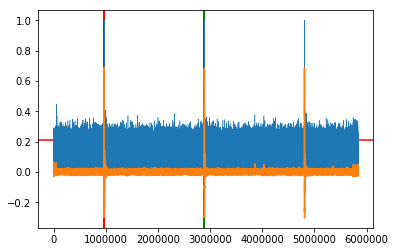


 4 ==================================
 snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2018/01/31/03/20180131030548860_HFN-R1_met.fits
HFN-R1
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2018/01/31/03/20180131030548860_HFN-R1_raws.fits
delka zaznamu          : 37.0 s
cas prvni. vzorku s GPS: 5.787682291666667 s
cas 1. GPS a konec     : 31.212317708333334 s
SysCas ukladani souboru: 2018-01-31 03:06:07 s
SysCas zacatku souboru : 2018-01-31 03:05:30
SysCas 1. GPS znacky   : 2018-01-31 03:05:35.787682
Korekce systemoveho cas: 0:00:04.212318
Korekce casu zvukovky  : 14.647681951522827 s
CorCas ukladani souboru: 2018-01-31 03:06:11.212318 s
CorCas zacatku souboru : 2018-01-31 03:05:34.212318
CorCas 1. GPS znacky   : 2018-01-31 03:05:40
Kvalita souboru        : 100
Pocet vzorku s gps znac: 2652


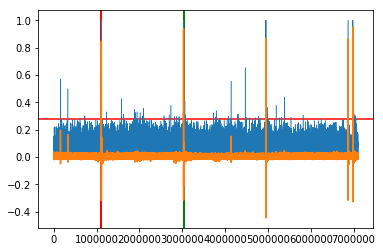

In [7]:
%matplotlib inline

help(MLABvo.Bolidozor.timeCalibration)
for i, bolid in enumerate(bolids.result):
    try:
        print("\n", i,"==================================\n", "snapshot:", bolid['url_file_js9'])
        print(bolid['station_name'])
        bolids.result[i]['time_calib'] = MLABvo.Bolidozor.timeCalibration(bolid['url_file_raw'],
                                         bolid['station_name'], sigma=15, browse_around=True, high_cut=500)
    except Exception as e:
        print("ERROR, bolids.result:", e)

Zde se vybegou všechny meteory ze shody

In [8]:
selected = list(range(0, len(bolids.result)))
time_offset = {}

Tento blok zjišťuje čas prvního vzorku na všech detekcích a čas posledního. Navíc to vykreslí graf znázorňující jednotlivé signály posunuté podle zjištěného offsetu

0 {'sys_error': datetime.datetime(2018, 1, 31, 3, 5, 41, 200000), 'cor_file_beg': datetime.datetime(2018, 1, 31, 3, 5, 42, 100383), 'sys_file_end': datetime.datetime(2018, 1, 31, 3, 5, 48), 'DATE-OBS': datetime.datetime(2018, 1, 31, 3, 5, 44), 'method': 'Around GPS', 'cor_1st_GPS': datetime.datetime(2018, 1, 31, 3, 5, 42, 100383), 'sys_file_beg': datetime.datetime(2018, 1, 31, 3, 5, 41, 200000), 'sys_1st_GPS': datetime.datetime(2018, 1, 31, 3, 5, 41, 200000), 'cor_file_end': datetime.datetime(2018, 1, 31, 3, 5, 48, 900383), 'quality': 50, 'sys_correction': datetime.timedelta(0), 'CRVAL2': 1517367944.222, 'samp_correction': 2.1216171082123765}
0 2018-01-31 03:05:42.100383 OBSUPICE-R6
1 {'sys_error': datetime.datetime(2018, 1, 31, 3, 5, 39, 408099), 'cor_file_beg': datetime.datetime(2018, 1, 31, 3, 5, 37, 191901), 'sys_file_end': datetime.datetime(2018, 1, 31, 3, 5, 44), 'DATE-OBS': datetime.datetime(2018, 1, 31, 3, 5, 39), 'method': 'GPS', 'cor_1st_GPS': datetime.datetime(2018, 1, 31, 3

KeyError: 'time_calib'

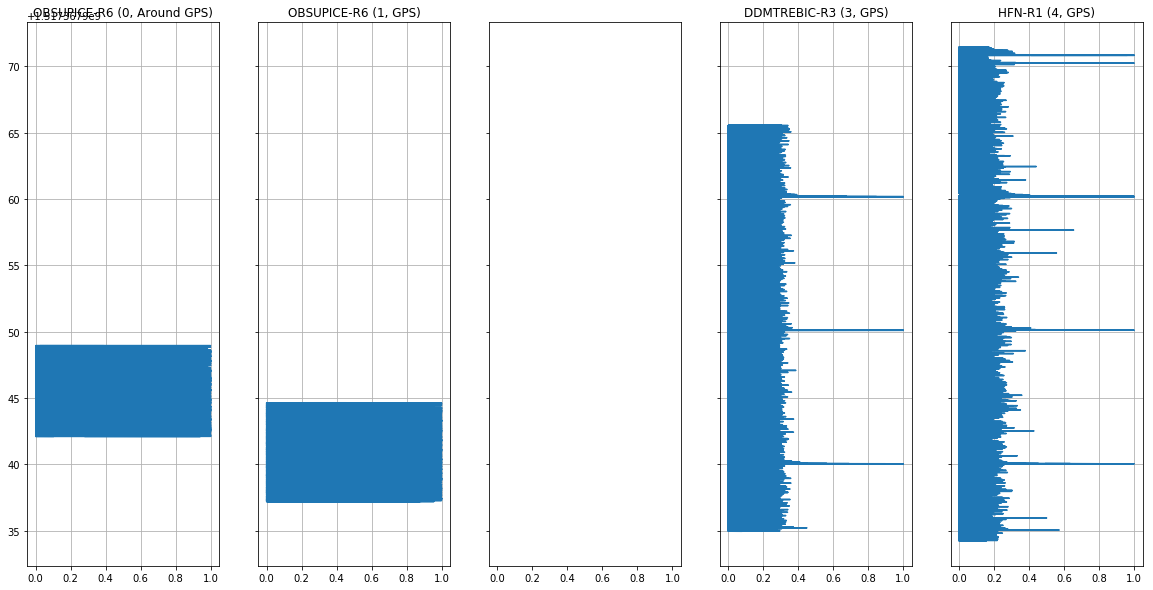

In [9]:
%matplotlib inline
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None
min_date = None
max_date = None

for i, ax in enumerate(axis):
    try:
        bolid = bolids.result[selected[i]]
        print(i, bolid['time_calib'])
        print (i, bolid['time_calib']['cor_file_beg'], bolid['namesimple'])
        hdulist = fits.open(bolid['url_file_raw'])
        met_data = np.abs(np.ravel(hdulist[0].data))

        T_offset = 10*time_offset.get(selected[i], 0)

        if gps_calib:
            ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
            min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            bolid['time_calib']['time_range']=[min_date, max_date]
        else:
            ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
            min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            bolid['time_calib']['time_range']=[min_date, max_date]
        #array = np.arange(min_date, max_date, 1/96000/2)
        array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))

        if not minimal_time: minimal_time = min_date
        if not maximal_time: maximal_time = max_date
        if min_date < minimal_time: minimal_time = min_date
        if max_date > maximal_time: maximal_time = max_date

        ax.plot(met_data, array)
        ax.grid(True)
    except Exception as e:
        print(e)

del min_date # dale pouzivat minimal_time
del max_date

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    T_offset = 10*time_offset.get(selected[i], 0)
    time_range = bolid['time_calib']['time_range']
    image_offset = time_range[0] - minimal_time + T_offset
    print("zpozdeni obrazku", np.round(image_offset*96000))
    bolid['time_calib']['sample_offset']=np.round(image_offset*96000)

fig.subplots_adjust(wspace=0.02, left = 0.02, right=0.98,bottom=0.02, top=0.97)
print(minimal_time, maximal_time)
plt.show()


Nyní je potřeba zkontrolovat, jestli předchozí algoritmus RAW data zarovnal správně. To lze zjistit podle GPS značek, že se nachází ve stejném čase. 

---

Tato funkce najde čas (oproti vygenerované trajktorii), kde je nulový vektor radiální rychlosti. Tento bod to zjistí pro každou detekci Následně to spočítá doplera v blízkém okolí extrémů nulového dopplera s vysokým rozlišením (odpovídajcímu vzorkovací frekvenci).

V druhé části to pro každý RAW záznam vygeneruje dopplera a pak ho převede na signál dopplera

vytvori se promenna '''doppler_list''', která bude obsahovat pocet sloupcu odpovidajici poctu detekci. V kazde bude odpovidajici doppler (s vysokym rozlisenim)

In [10]:
%matplotlib inline

timesteps = np.arange(-30,30,0.1)
dopplers_null = []

#met_velocity = [60500]
#model_offset = 3


# vypocet dopplera s malym rozlisenim (jen pro urceni nuloveho posunu)
for meteor in selected:
    bolid = bolids.result[selected[meteor]]
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
    station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))
    met_points = generate_path(met_start_point, met_stop_point, met_velocity[0], timesteps)
    doppler = MLABvo.BolidozorTools.estimate_dopplers(met_points, timesteps, 143050000, trans_station_point, station_point)
    
    doppler_zero_index = np.argmin(np.abs(doppler[:,1]))
    doppler_zero_time = doppler[doppler_zero_index][0]
    dopplers_null.append([doppler_zero_time])   
    
print("probehl vypocet dopplera s malym rozlisenim, casy jsou %s az %s." %(np.min(dopplers_null), np.max(dopplers_null)))

okoli = 5   ## Jake okoli nuloveho dopplera generovat v [s]
#timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 1/96000)
timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 1/9600)
#timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 0.05)
print("Časová řada má prvků:", len(timesteps))

probehl vypocet dopplera s malym rozlisenim, casy jsou -30.0 az -30.0.
Časová řada má prvků: 96000


zacatek vypoctu s vysokym rozlisenim pro jednu stanici
zacatek vypoctu s vysokym rozlisenim pro jednu stanici
zacatek vypoctu s vysokym rozlisenim pro jednu stanici
zacatek vypoctu s vysokym rozlisenim pro jednu stanici
zacatek vypoctu s vysokym rozlisenim pro jednu stanici


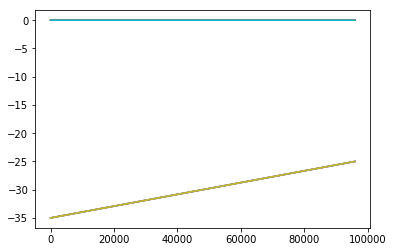

CPU times: user 26.1 s, sys: 272 ms, total: 26.4 s
Wall time: 26.4 s


In [11]:
%%time

# vypocet dopplera s vysokym rozlisenim (pro presne urceni dopplera v okamzik nulove radialni rychlosti)
for meteor in selected:
    print("zacatek vypoctu s vysokym rozlisenim pro jednu stanici")
    bolid = bolids.result[selected[meteor]]

    # prevedou se souradnice do kartezke soustavy a nasledne se spocita trajektorie (vektor) meteoru
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
    station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))
    met_points = generate_path(met_start_point, met_stop_point, met_velocity[0], timesteps)

    # Vytvoreni modelu head-echa (dopplerovsky posuv modelu) 
    doppler = MLABvo.BolidozorTools.estimate_dopplers(met_points, timesteps, 143050000, trans_station_point, station_point)
    #doppler_O = estimate_dopplers(met_points, timesteps, 143050000, trans_station_point, station_point)
    
    # zapise se index bodu simulace, kde je dopplerovsky posuv nulovy
    bolids.result[selected[meteor]]['doppler_zero_index'] = np.argmin(np.abs(doppler[:,1])) # doppler zero index (index, kde je nejmensi dopplerovsky posuv)
    
    # Prevod dopplerovsych frekvenci na signal
    # !!! Nejsem si jist, jestli toto provadim spravne
    dt = timesteps[1]-timesteps[0]
    signal = (np.sin(2*np.pi*dt*np.cumsum(np.interp(np.arange(len(doppler)), doppler[:,0], doppler[:, 1]))))
    
    #zapsat signal dopplera a frekvence dopplera k meteoru
    bolids.result[selected[meteor]]['doppler_signal'] = signal
    bolids.result[selected[meteor]]['doppler_frequency'] = doppler
    plt.plot(doppler)

plt.show()

# Alternativní přístup pro namodelování headecha

Tento přístup spočívá v namodelování situace pomocí symbolické rovnice.

In [12]:
import sympy as sp
from scipy import constants

In [13]:

def doppler_equation(freq = 143050000, delta = True):
    M1_x = sp.Symbol('M1_x')
    M1_y = sp.Symbol('M1_y')
    M1_z = sp.Symbol('M1_z')

    M2_x = sp.Symbol('M2_x')
    M2_y = sp.Symbol('M2_y')
    M2_z = sp.Symbol('M2_z')

    VEL = sp.Symbol('Velocity')

    TX_x = sp.Symbol('TX_x')
    TX_y = sp.Symbol('TX_y')
    TX_z = sp.Symbol('TX_z')

    RX_x = sp.Symbol('RX_x')
    RX_y = sp.Symbol('RX_y')
    RX_z = sp.Symbol('RX_z')

    t = sp.Symbol('time')

    TX = sp.Matrix([TX_x, TX_y, TX_z])  # poloha vysilace
    RX = sp.Matrix([RX_x, RX_y, RX_z])  # poloha stanice
    M1 = sp.Matrix([M1_x, M1_y, M1_z])  # prvni souradnice trajektorie
    M2 = sp.Matrix([M2_x, M2_y, M2_z])  # druha souradnice trajektorie
    MV = (M2-M1).normalized()        # normalizovany vektor trajoktie

    # poloha meteoru v case 'time'
    MT = M1 + MV*VEL*t

    #B_pn = (RX-TX).cross((RX-MT)) # bistatic plane normal

    #Vmt = (TX-MT).normalized()
    #Vmr = (RX-MT).normalized()
    #Vba = Vmt+Vmr
    
    Rt = TX-MT
    Rr = RX-MT
    Rsum = sp.diff((Rt+Rr).dot(sp.Matrix([1,1,1])), 'time')

    #l1, l2 = sp.Line3D(MT, TX), sp.Line3D(MT, RX)
    #bistatic_angle = l1.angle_between(l2)
    
    #l1, l2 = sp.Line3D(MT, MT+Vba), sp.Line3D(MT, MT+MV)
    #l1, l2 = sp.Line3D(MT, RX), sp.Line3D(MT, MT+MV)
    #angle = l1.angle_between(l2)

    #doppler = (int(not delta)+(sp.acos(angle)*VEL)/(constants.c))*freq
    #doppler = freq * (sp.cos(angle - bistatic_angle/2)*VEL) / constants.c
    
    print(sp.diff(Rt.dot(sp.Matrix([1,1,1])), 'time'), Rr)
    doppler = (VEL/constants.c)*Rsum
    
    return doppler

In [14]:
%%time

echo_equation = MLABvo.BolidozorTools.doppler_equation().subs({
#echo_equation = doppler_equation().subs({
    "TX_x": trans_station_point[0],
    "TX_y": trans_station_point[1],
    "TX_z": trans_station_point[2]
})

CPU times: user 2min 24s, sys: 347 ms, total: 2min 24s
Wall time: 2min 27s


Vypocet pomoci symbolickeho vypoctu
Vypocet pomoci symbolickeho vypoctu
Vypocet pomoci symbolickeho vypoctu
Vypocet pomoci symbolickeho vypoctu
Vypocet pomoci symbolickeho vypoctu


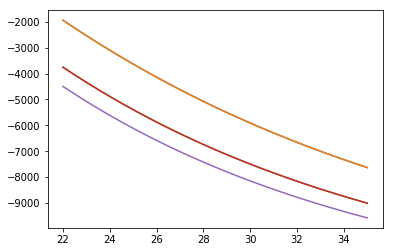

CPU times: user 1min 48s, sys: 345 ms, total: 1min 48s
Wall time: 1min 51s


In [15]:
%%time

#okoli = 20   ## Jake okoli nuloveho dopplera generovat v [s]
#timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 1/96000)
timesteps = np.arange(22, 35, 1/9600)
#timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 0.05)


# vypocet dopplera s vysokym rozlisenim (pro presne urceni dopplera v okamzik nulove radialni rychlosti)
for i, meteor in enumerate(selected):
    print("Vypocet pomoci symbolickeho vypoctu")
    bolid = bolids.result[selected[meteor]]

    # prevedou se souradnice do kartezke soustavy a nasledne se spocita trajektorie (vektor) meteoru
    met1_co = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
    met2_co = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
    stat_co = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                       stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))
    echo = echo_equation.subs({
        'RX_x': stat_co[0],
        'RX_y': stat_co[1],
        'RX_z': stat_co[2],

        'M1_x': met1_co[0],
        'M1_y': met1_co[1],
        'M1_z': met1_co[2],

        'M2_x': met2_co[0],
        'M2_y': met2_co[1],
        'M2_z': met2_co[2],
        
        'Velocity': met_velocity[0]
    })
    
    #print("a")
    #print("Nulový doppler", sp.solve(echo, 'time', minimal=True, check=False, quick=True))

    echo_x = sp.lambdify('time', echo, modules=['numpy'])
    y_vals = echo_x(timesteps)
    bolids.result[selected[meteor]]['doppler_frequency2'] = y_vals
    
    #sp.plot(echo, ('time', -100, 100))
    plt.plot(timesteps, y_vals)

plt.show()

Dále se vezme signál a bude se hledat nejlepší korelace.

In [16]:
##### %matplotlib inline 
#%matplotlib notebook
%matplotlib wx

import matplotlib.dates as md
from matplotlib import dates
from matplotlib import interactive
interactive(True)

#timesteps = np.arange(np.min(dopplers_null)-okoli, np.max(dopplers_null)+okoli, 0.05)


count = len(bolids.result)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

#meteor_dopplers = [1,2]
#timesteps = np.arange(-20,20,0.2)
#met_points = np.empty([timesteps.size, 3])
#met_velocity = [45500]
#model_offset = 2.2

for meteor in range(len( bolids.result)):
    try:
        # get meteor vector from start and stop point

       # met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor]))
       # met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor]))
       # met_vect = met_stop_point - met_start_point
        #print(met_vect)

        #for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        #    met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[meteor]))
        #print("generation of points DONE")

        print(time_offset)
        fig.suptitle("Multibolid %s (%s), velocity: %s" %(datetime.datetime.utcfromtimestamp(minimal_time).date(), "CB bolid", 0))
        fig.subplots_adjust(hspace=0)
        plt.set_cmap('hot')
        #for i, ax in enumerate(axis):
        if True:
            i = meteor
            ax = axis[i]

            bolid = bolids.result[i]
            print(i, bolid['id_observer'])

            hdu = fits.open(bolid['url_file_raw'])[0]
            flat_data = np.ravel(hdu.data)
            raw = flat_data[0::2] + 1j * flat_data[1::2]  # Bolidozor signal

            #T_offset = datetime.timedelta(seconds = 10*time_offset.get(i, 0))
            #print(i, selected[i], bolid['time_calib']['cor_file_beg'], bolid['time_calib']['cor_file_beg']+T_offset, T_offset)
            d1 = bolid['time_calib']['cor_file_beg']
            fds1 = dates.date2num(d1) # converted
            d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/96000)
            fds2 = dates.date2num(d2)
            raw_timestep = np.arange(d1.timestamp(), d2.timestamp(), 1/96000)
            #print(fds1, fds2, fds2-fds1)


            ## optical doppler
            #for station in stations:
            #rec_station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
            #                                                         stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))

            #doppler_t(met_points, timesteps, f0, trans_station_point, rec_station_point)
            #doppler = estimate_dopplers2(met_points, timesteps, f0, trans_station_point, rec_station_point)
            #if 'doppler_zero_index' not in locals():
            #    doppler_zero_index = np.argmin(np.abs(doppler[:,1][1:-1]))+1
            #    doppler_zero_time = doppler[doppler_zero_index][0]

            dopp_time = np.vectorize(lambda x: dates.date2num(d1+datetime.timedelta(seconds=(x-doppler_zero_time+model_offset))))
            dopp_freq = np.vectorize(lambda x: ((x)+26500.0))
            #ax.plot(dopp_freq(bolid['doppler_frequency'][1:,1]), dopp_time(bolid['doppler_frequency'][1:,0]), 'blue')
            ax.plot(dopp_freq(bolid['doppler_frequency2']), dopp_time(timesteps-60), 'green')

            ######### ^^^^^^^^
            ########

            # Bolidozor
            #print(raw)
            arr = MLABvo.BolidozorTools.waterfall(raw, None, bins = 4096*2)
            ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-48000, 48000, fds2, fds1])
            ax.grid(True)

            ax.set_xlim(13000*2,13500*2)
            ax.yaxis_date()
            date_format = md.DateFormatter('%H:%M:%S')
            ax.yaxis.set_major_formatter(date_format)
            fig.autofmt_xdate()
            ax.set_ylim( datetime.datetime.utcfromtimestamp(minimal_time), datetime.datetime.utcfromtimestamp(maximal_time))

            ax.set_title(str(bolid['id_observer']) + " - " + bolid.get('station_name', '-'))
    except Exception as e: print(e)
            
fig.subplots_adjust(wspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)
#plt.savefig('output.png', dpi=300)

#plt.close(fig)
plt.show(fig)
plt.gcf()
#plt.ioff()
#plt.gcf().show()
#plt.show()

ImportError: Matplotlib backend_wx and backend_wxagg require wxPython >=2.8.12

In [ ]:
##### np.appen
surround = 1

#for meteor in selected:
if True: # tady pak bude for pro vsechny stanice
    meteor = 0
    bolid = bolids.result[selected[meteor]]
    hdulist = fits.open(bolid['url_file_raw'])
    raw = hdulist[0].data[:,0] + hdulist[0].data[:,1] * 1j
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
    
    print("delka meteoru je", raw.shape[0], 'vzorků a delka vygenerovaneho dopplera je na indexu', bolid['doppler_signal'].shape[0], 'vzorku. Vzorek s nulovym dopplerem oproti modelu je', repr(bolid['doppler_zero_index']))
    
    doppler = bolid['doppler_frequency']
    doppler_signal = np.empty_like(raw)
    doppler_freq_c = bolid['doppler_signal'][int(bolid['doppler_zero_index']-surround*96000):int(bolid['doppler_zero_index']+surround*96000)]
    np.put(doppler_signal, np.arange(len(doppler_freq_c)), doppler_freq_c, mode='crop')

    cor = scipy.signal.correlate(raw, doppler_signal, 'same')

    l1 = range(len(raw.real))
    l2 = range(len(doppler[1:,0][96000*2:]))

    ax1.plot(np.abs(raw))
    ax1.set_xlim(0,len(raw.real))

    arr = waterfall(raw, None, bins = 4096*2)
    ax2.imshow(arr.T,  interpolation='none', aspect='auto',  extent=[0, len(raw.real),48000, -48000], cmap=plt.get_cmap('hot'))
    ax2.grid(True)
    ax2.set_ylim(13000*2,13500*2)
    ax2.plot(np.arange(1, len(doppler[:,1])), doppler[1:,1]+26500.0)
    ax2.plot(np.arange(0, len(2+doppler[:,1][int(bolid['doppler_zero_index']-surround*96000):int(bolid['doppler_zero_index']+surround*96000)]))+0, doppler[1:,1][int(bolid['doppler_zero_index']-surround*96000):int(bolid['doppler_zero_index']+surround*96000)]+26500.0)


   
    ax3.plot(doppler_signal)
    ax3.set_ylim(-300,300)
    fig.subplots_adjust(wspace=0.04, hspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)

Na předchozí blok lze navázat. Jsou tam obsažena všechna potřebná data - RAW signál, začátek RAW souboru, doppler, signál dopplera

# stare kody a ruzne pokusy  - ted uz asi casto nefunkcni

In [ ]:
##
##
##
##

%matplotlib tk

meteor = 0

bolid = bolids.result[selected[meteor]]
hdulist = fits.open(bolid['url_file_raw'])
raw = hdulist[0].data[:,0] + hdulist[0].data[:,1] * 1j

if gps_calib:
    #ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
    min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
else:
    #ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
    min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
    max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))


met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))
station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))


In [ ]:
print('met_points', met_points)
print('timpstaps', timesteps)
print('rec_station_point', rec_station_point)
print('trans_station_point', trans_station_point)

doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, rec_station_point)
doppler_zero_index = np.argmin(np.abs(doppler[:,1]))
doppler_zero_time = doppler[doppler_zero_index][0]

dopp_time = np.vectorize(lambda x: dates.date2num(d1+datetime.timedelta(seconds=(x)+model_offset)))
dopp_freq = np.vectorize(lambda x: ((x)+26500.0))

print(raw)
print(doppler)
print("doppler_zero_time", doppler_zero_time, "@", doppler_zero_index)



In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
sample_offset = -doppler_zero_index + int(96000*(1.6706))
#sample_offset = -doppler_zero_index + int(96000*(-2.479))  #asi optimalni
#sample_offset = -doppler_zero_index + int(96000*(-2))
#sample_offset = -doppler_zero_index + int(96000*(-1))
#sample_offset = -doppler_zero_index + int(96000*(0))


x = np.arange(len(doppler[1:,1]))
#y = 1*np.sin(2 * np.pi * doppler[1:,1] * x / 96000)
#y = 1*np.sin(2 * np.pi * freq * x / sr)


korekce = np.add.accumulate(len(doppler[1:,1])*np.concatenate((np.zeros(1), 2*np.pi*(doppler[1:,1][:-1]-doppler[1:,1][1:]))))
y = np.sin(2*np.pi*doppler[1:,1]*len(doppler[1:,1]))*10
#y2= np.sin(2*np.pi*doppler[1:,1]*len(doppler[1:,1]))

doppler_signal = np.zeros_like(raw)
np.put(doppler_signal, np.arange(1, len(y))+sample_offset, y, mode='crop')

print(doppler_signal)
print(raw)
print("dopplerTime")
print(doppler[1:,0])

cor = scipy.signal.correlate(raw, doppler_signal, 'same')

l1 = range(len(raw.real))
l2 = range(len(doppler[1:,0][96000*2:]))

#ax1.plot(l1, doppler_signal.real, l1, cor.imag)
ax1.plot(l1, raw.real, l1, raw.imag)
ax1.set_xlim(0,len(raw.real))


arr = waterfall(raw, None, bins = 4096*2)
ax2.imshow(arr.T,  interpolation='none', aspect='auto',  extent=[0, len(raw.real),48000, -48000], cmap=plt.get_cmap('hot'))
ax2.grid(True)
ax2.set_ylim(13000*2,13500*2)
ax2.plot(np.arange(1, len(doppler[:,1]))+sample_offset, doppler[1:,1]+26500.0)


print("suma", np.sum(np.abs(cor)))
#ax3.plot(scipy.signal.correlate(doppler_signal, raw.real, 'same').real)
#ax3.plot(cor)
#ax3.plot(scipy.signal.convolve(raw.real, doppler_signal, 'same').real)
#ax3.plot(y2)
ax3.plot(y)
ax3.set_ylim(-300,300)
fig.subplots_adjust(wspace=0.04, hspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)




In [ ]:
con = []
for x in np.arange(1.655,1.67,10/96000):
    sample_offset = int(-doppler_zero_index + int(96000*(x)))
    doppler_signal = np.zeros_like(raw)
    np.put(doppler_signal, np.arange(1, len(y))+sample_offset, y, mode='crop')
    cor = scipy.signal.correlate(doppler_signal, raw, 'same')
    s = np.sum(np.abs(cor[96000*int(x-0.5):96000*int(x+0.5)]))
    print(x, s)
    con.append([x, s])
con = np.array(con)
print(con[:,0])
plt.plot(con[:,0], con[:,1])

In [ ]:
delp = 0
dela = 0
runc = 1 # pet nahodnych prubehu
timesteps = np.arange(-10,5,1/96000)
    
    
for runi in np.arange(runc):
    doppler_zero_index = None
    met_start_lat_rand = met_start_lat + np.random.ranf(met_start_lat.shape)*2*delp-delp
    met_start_lon_rand = met_start_lon + np.random.ranf(met_start_lon.shape)*2*delp-delp
    met_start_alt_rand = met_start_altitude + np.random.ranf(met_start_altitude.shape)*2*dela-dela
    met_stop_lat_rand = met_stop_lat + np.random.ranf(met_stop_lat.shape)*2*delp-delp
    met_stop_lon_rand = met_stop_lon + np.random.ranf(met_stop_lon.shape)*2*delp-delp
    met_stop_alt_rand = met_stop_altitude + np.random.ranf(met_stop_altitude.shape)*2*dela-dela
    met_velocity = np.random.randint(20000,50000, 1)
    
    met_points = np.empty([timesteps.size, 3])
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat_rand[0], met_start_lon_rand[0], met_start_alt_rand[0]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat_rand[0], met_stop_lon_rand[0], met_stop_alt_rand[0]))
    met_vect = met_stop_point - met_start_point
    print("meteor vector", met_vect)
    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[0]))
    print("generation of points DONE")
    

In [ ]:
#%matplotlib tk
#%matplotlib notebook
%matplotlib inline
import time


if True:
    #
    #  tady zacne for pro kazdou stanici
    #
    for meteor in np.arange(3):
        con = []
        bolid = bolids.result[selected[meteor]]
        hdulist = fits.open(bolid['url_file_raw'])
        raw = hdulist[0].data[:,0] + hdulist[0].data[:,1] * 1j
    
        rec_station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                     stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))

        #doppler = estimate_dopplers2(met_points, timesteps, 143050000, trans_station_point, rec_station_point)
        doppler = bolid['doppler']
        x = np.arange(len(doppler)-1)
        y = 1*np.sin(2 * np.pi * doppler[1:,1] * x / 96000)
        if not doppler_zero_index:
            doppler_zero_index = np.argmin(np.abs(doppler[:,1][1:-1]))+1
            doppler_zero_time = doppler[doppler_zero_index][0]
        #print(bolid['namesimple'])
        
        
        for dtime in np.arange(1,7,1/96000*2000):
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20, 10))
            ax1.plot(raw.real)
            ax1.plot(doppler)
            doppler_signal = np.zeros_like(raw)
            zeroi = doppler_zero_index+int(dtime*69000)
            np.put(doppler_signal, np.arange(1, len(y))-doppler_zero_index+int(dtime*69000), y, mode='crop')
            ax2.plot(doppler_signal.real)
            #plt.show()
            #time.sleep(10)
            cor = scipy.signal.correlate(doppler_signal, raw, 'same')
            ax3.plot(cor.real)
            plt.savefig(bolid['namesimple']+str(dtime)+".png")
            plt.close()
            s = np.sum(np.abs(cor[int((dtime-0.5)*69000):int((dtime+0.5)*69000)]))/1e4
            print(dtime, s)
            con.append([dtime, s])
        con = np.array(con)
        print(bolid['namesimple'], "tahle stanice byla zpracovana")
        plt.plot(con[:,0], con[:,1], label=bolid['namesimple'])
        


In [ ]:
def estimate_dopplers2(trajectory, timesteps, f0, trans_station, rec_station):
    # alternative algorithm
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
   
    doppler = np.empty([trajectory.shape[0], 2])
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        try: 
            # angle transmitter - meteor - reciever
            ba = trans_station-trajectory[i]
            bc = rec_station-trajectory[i]
            TMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))

            # angle trajectory - meteor - reciever
            ba = trajectory[i+1]-trajectory[i]
            bc = rec_station-trajectory[i]
            VMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))
            # angle trajectory - meteor - axis (of angle transmitter-meter-reciever)
            VMA = VMR-TMR/2
            #print(np.degrees(VMA))

            # radial speed of meteor to axis of TMR angle (Transmitter - meteor - reciever)
            radial_speed = np.cos(VMA)*(np.linalg.norm(trajectory[i]-trajectory[i+1])/t)
            doppler_offset = (radial_speed/c)*f0
            
        except Exception as e:
            #print(e)
            pass
        
        doppler[i] = np.array([timesteps[i], doppler_offset])
    return doppler



In [ ]:
estimate_doppler()